# Laboratorio 3

In [1]:
# Libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Util Functions

In [2]:
def create_short_preamble():
    short_preamble_data = """
    16 0.046 0.046 56 0.046 0.046 96 0.046 0.046 136 0.046 0.046
    17 -0.132 0.002 57 0.002 -0.132 97 -0.132 0.002 137 0.002 -0.132
    18 -0.013 -0.079 58 -0.079 -0.013 98 -0.013 -0.079 138 -0.079 -0.013
    19 0.143 -0.013 59 -0.013 0.143 99 0.143 -0.013 139 -0.013 0.143
    20 0.092 0.000 60 0.000 0.092 100 0.092 0.000 140 0.000 0.092
    21 0.143 -0.013 61 -0.013 0.143 101 0.143 -0.013 141 -0.013 0.143
    22 -0.013 -0.079 62 -0.079 -0.013 102 -0.013 -0.079 142 -0.079 -0.013
    23 -0.132 0.002 63 0.002 -0.132 103 -0.132 0.002 143 0.002 -0.132
    24 0.046 0.046 64 0.046 0.046 104 0.046 0.046 144 0.046 0.046
    25 0.002 -0.132 65 -0.132 0.002 105 0.002 -0.132 145 -0.132 0.002
    26 -0.079 -0.013 66 -0.013 -0.079 106 -0.079 -0.013 146 -0.013 -0.079
    27 -0.013 0.143 67 0.143 -0.013 107 -0.013 0.143 147 0.143 -0.013
    28 0.000 0.092 68 0.092 0.000 108 0.000 0.092 148 0.092 0.000
    29 -0.013 0.143 69 0.143 -0.013 109 -0.013 0.143 149 0.143 -0.013
    30 -0.079 -0.013 70 -0.013 -0.079 110 -0.079 -0.013 150 -0.013 -0.079
    31 0.002 -0.132
    """
    short_preamble = []
    for _, i, q in zip(*(iter(short_preamble_data.split()),)*3):
        short_preamble.append(complex(float(i), float(q)))
    return np.array(short_preamble)

In [3]:
def rrc_filter(beta, sps, num_taps):
    """Genera un filtro de Coseno Elevado Raíz (RRC)."""
    t = np.arange(-num_taps//2, num_taps//2 + 1) / sps
    pi_t = np.pi * t
    four_beta_t = 4 * beta * t

    with np.errstate(divide='ignore', invalid='ignore'):
        numerator = np.sin(pi_t * (1 - beta)) + 4 * beta * t * np.cos(pi_t * (1 + beta))
        denominator = pi_t * (1 - (four_beta_t) ** 2)
        h = numerator / denominator

    # Manejo de t = 0
    h[np.isnan(h)] = 1.0 - beta + (4 * beta / np.pi)
    # Manejo de t = ±1/(4β)
    t_special = np.abs(t) == (1 / (4 * beta))
    h[t_special] = (beta / np.sqrt(2)) * (
        ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta))) +
        ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    )

    # Normalizar el filtro
    h /= np.sqrt(np.sum(h**2))

    return h

In [4]:
def estimate_and_correct_cfo(received_signal, L):
    """
    Estima y corrige el desplazamiento de frecuencia usando el preámbulo largo.
    """
    # Obtener segmentos de preámbulo
    preamble_segment_1 = received_signal[:L]
    preamble_segment_2 = received_signal[L:2*L]

    # Estimar el desplazamiento de frecuencia usando la fase entre segmentos de preámbulo
    A = np.vdot(preamble_segment_1, preamble_segment_2)
    freq_offset_est = np.angle(A) / (2 * np.pi * L)
    print(f"Desplazamiento de frecuencia estimado (CFO): {freq_offset_est}")

    # Corregir el desplazamiento de frecuencia
    sample_rate = L
    t = np.arange(len(received_signal)) / sample_rate
    received_signal_corrected = received_signal * np.exp(-1j * 2 * np.pi * freq_offset_est * t)

    return received_signal_corrected

In [5]:
def schmidl_cox_algorithm_vectorized(signal, L, threshold=0.8):
    # Calcular P(d)
    P = np.zeros(len(signal) - 2*L + 1, dtype=complex)
    P = np.correlate(signal[L:], np.conj(signal[:-L]), mode='valid')

    # Calcular R(d)
    power = np.abs(signal)**2
    R = np.convolve(power[L:], np.ones(L), mode='valid')

    # Calcular M(d)
    M = np.abs(P) / R
    M /= np.max(M)

    # Detectar picos
    peaks = np.where(M > threshold)[0]
    if len(peaks) > 0:
        d_max = peaks[0]
        return d_max, M
    else:
        return None, M


## Trasmitter

In [6]:
def simulate_transmission(signal, snr_db):
    """Simula la transmisión sobre un canal AWGN."""
    # Calcular potencia de señal y ruido
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generar ruido blanco gaussiano
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))
    )

    # Añadir ruido a la señal
    received_signal = signal + noise
    return received_signal

In [7]:
# Parámetros de configuración
samples_per_symbol = 8  # Muestras por símbolo
beta = 0.2  # Factor de roll-off del filtro RRC
num_taps = 101  # Número de taps del filtro RRC
snr_db = 30  # Relación señal a ruido en dB

# Desfase y CFO
phase_offset = np.pi / 6  # Desfase de 30 grados
frequency_offset = 0.01  # Desplazamiento de frecuencia normalizado

# Semilla aleatoria para reproducibilidad
np.random.seed(0)

# Generar preámbulo
half_preamble_bits = np.random.randint(0, 2, size=10)  # 10 bits
preamble_bits = np.concatenate((half_preamble_bits, half_preamble_bits))
preamble_symbols = 2 * preamble_bits - 1
np.save('preamble_bits.npy', preamble_bits)
# Cargar imagen
image = Image.open('Escudo_UNSA.png')  
image = image.convert('RGB')
width, height = image.size
image_array = np.array(image)
image_flat = image_array.flatten()
image_bits = np.unpackbits(image_flat)
print(f"Imagen cargada: {width}x{height} píxeles")
print(f"Bits de imagen: {image_bits}")
# Crear encabezado con el tamaño de la imagen
width_bytes = np.array([width], dtype='>u2').view(np.uint8)
height_bytes = np.array([height], dtype='>u2').view(np.uint8)
width_bits = np.unpackbits(width_bytes)
height_bits = np.unpackbits(height_bytes)
header_bits = np.concatenate((width_bits, height_bits))

np.save('header_bits.npy', header_bits)

# Concatenar preámbulo, encabezado y bits de imagen
bits = np.concatenate((preamble_bits, header_bits, image_bits))

np.save('transmitted_bits.npy', bits)
# Mapear bits a símbolos BPSK (-1, +1)
symbols = 2 * bits - 1
print(f"Símbolos BPSK generados: {symbols}")
# Sobremuestrear símbolos
symbols_upsampled = np.zeros(len(symbols) * samples_per_symbol)
symbols_upsampled[::samples_per_symbol] = symbols

# Generar filtro RRC
rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)

# Filtrar la señal
signal_filtered = np.convolve(symbols_upsampled, rrc_coef, mode='same')

# Normalizar amplitud de la señal
signal_filtered /= np.max(np.abs(signal_filtered))

# Aplicar desfase y CFO
sample_rate = samples_per_symbol  # Tasa de muestreo normalizada
t = np.arange(len(signal_filtered)) / sample_rate
signal_complex = signal_filtered * np.exp(1j * (2 * np.pi * frequency_offset * t + phase_offset))
# Simular transmisión sobre un canal AWGN
received_signal = simulate_transmission(signal_complex, snr_db)

# Guardar la señal recibida para el receptor
np.save('received_signal.npy', received_signal)

print("Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.")


Imagen cargada: 488x599 píxeles
Bits de imagen: [0 0 0 ... 0 0 0]
Símbolos BPSK generados: [-1  1  1 ... -1 -1 -1]
Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.


## Receiver

In [8]:
samples_per_symbol = 8
beta = 0.2
num_taps = 101
np.random.seed(0)
half_preamble_bits = np.random.randint(0, 2, size=10)
preamble_bits = np.concatenate((half_preamble_bits, half_preamble_bits))
preamble_symbols = 2 * preamble_bits - 1
received_signal = np.load('received_signal.npy')
L = len(half_preamble_bits) * samples_per_symbol
print(f"Longitud de la mitad del preámbulo en muestras: {L}")
d_max, M = schmidl_cox_algorithm_vectorized(received_signal, L)
if d_max is not None:
    print(f"Preámbulo detectado en el índice: {d_max}")
    # Estimación del desplazamiento de frecuencia
    A = np.sum(received_signal[d_max:d_max+L] * np.conj(received_signal[d_max+L:d_max+2*L]))
    freq_offset_est = np.angle(A) / (2 * np.pi * L)
    print(f"Desplazamiento de frecuencia estimado (CFO): {freq_offset_est}")
    # Corregir el desplazamiento de frecuencia
    t = np.arange(len(received_signal))
    received_signal *= np.exp(-1j * 2 * np.pi * freq_offset_est * t)
    # Filtrado adaptado con filtro RRC
    rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)
    matched_filtered_signal = np.convolve(received_signal, rrc_coef, mode='same')
    # Ajuste por retraso de grupo del filtro
    group_delay = (num_taps - 1) // 2
    # Muestreo
    symbol_indices = d_max + group_delay + np.arange(0, len(matched_filtered_signal) - d_max - group_delay, samples_per_symbol)
    symbol_indices = symbol_indices.astype(int)
    sampled_symbols = matched_filtered_signal[symbol_indices]
    # Limitar a la longitud de los símbolos transmitidos
    transmitted_bits = np.load('transmitted_bits.npy')
    num_symbols = len(transmitted_bits)
    sampled_symbols = sampled_symbols[:num_symbols]
    # Extraer los símbolos recibidos correspondientes al preámbulo
    preamble_received = sampled_symbols[:len(preamble_symbols)]
    # Estimación y corrección del desfase
    phase_estimate = np.angle(np.sum(preamble_received * np.conj(preamble_symbols)))
    print(f"Desfase estimado: {phase_estimate}")
    # Corregir el desfase
    sampled_symbols *= np.exp(-1j * phase_estimate)
    # Decodificar símbolos a bits
    received_bits = (np.real(sampled_symbols) > 0).astype(np.uint8)
    # Cargar bits transmitidos para comparación
    transmitted_bits = np.load('transmitted_bits.npy')
    preamble_bits_tx = np.load('preamble_bits.npy')
    header_bits_tx = np.load('header_bits.npy')
    # Comparar bits de preámbulo
    preamble_match = np.array_equal(received_bits[:len(preamble_bits)], preamble_bits_tx)
    print(f'Preamble bits match: {preamble_match}')
    # Comparar bits de encabezado
    header_bits = received_bits[len(preamble_bits):len(preamble_bits)+32]
    header_match = np.array_equal(header_bits, header_bits_tx)
    print(f'Header bits match: {header_match}')
    # Continuar solo si los bits del encabezado coinciden
    if not header_match:
        print("Los bits del encabezado no coinciden. No se puede continuar.")
    else:
        # Convertir bits de encabezado a ancho y alto
        width_bits = header_bits[:16]
        height_bits = header_bits[16:32]
        width_bytes = np.packbits(width_bits)
        height_bytes = np.packbits(height_bits)
        # Convertir bytes a enteros
        width = int(np.frombuffer(width_bytes.tobytes(), dtype='>u2')[0])
        height = int(np.frombuffer(height_bytes.tobytes(), dtype='>u2')[0])
        print(f"Ancho de imagen: {width}, Alto de imagen: {height}")
        # Calcular el número de bits para la imagen
        num_image_bits = width * height * 3 * 8  # 3 colores (RGB), 8 bits por color
        # Extraer bits de imagen
        total_bits_needed = len(preamble_bits) + 32 + num_image_bits
        if len(received_bits) < total_bits_needed:
            print("No se recibieron suficientes bits para reconstruir la imagen.")
        else:
            image_bits = received_bits[len(preamble_bits)+32:total_bits_needed]
            # Convertir bits a bytes
            image_bytes = np.packbits(image_bits)
            # Convertir bytes a matriz de imagen
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            # Verificar tamaño esperado
            expected_size = width * height * 3
            if image_array.size != expected_size:
                print(f"Tamaño esperado de la imagen: {expected_size}, pero se obtuvo: {image_array.size}")
                print("No se puede reestructurar la matriz debido a una discrepancia de tamaño.")
            else:
                image_array = image_array.reshape((height, width, 3))
                # Crear y mostrar la imagen
                image = Image.fromarray(image_array, 'RGB')
                image.show()
else:
    print("No se detectó el preámbulo en la señal recibida.")

Longitud de la mitad del preámbulo en muestras: 80
Preámbulo detectado en el índice: 0
Desplazamiento de frecuencia estimado (CFO): -0.0012373636271249923
Desfase estimado: 0.5783019538614504
Preamble bits match: False
Header bits match: False
Los bits del encabezado no coinciden. No se puede continuar.


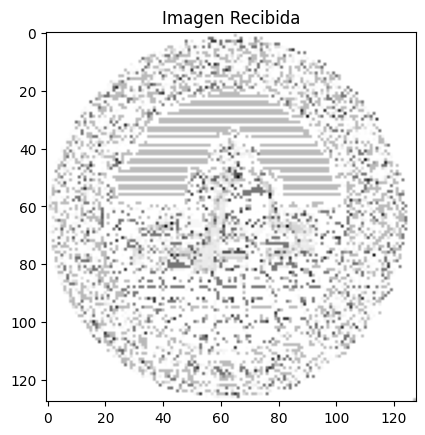

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image

# Parámetros
sps = 8  # Muestras por símbolo
rolloff = 0.35  # Factor de roll-off para el filtro de coseno elevado
num_taps = 101  # Número de coeficientes del filtro
EbN0_dB = 10  # Relación Eb/N0 en decibelios
fs = 1e6  # Frecuencia de muestreo en Hz

# 1. Convertir la imagen en una secuencia de bits
def image_to_bits(image_path):
    img = Image.open(image_path).convert('L')  # Convertir a escala de grises
    img = img.resize((128, 128))  # Redimensionar para simplificar
    img_array = np.array(img)
    bits = np.unpackbits(img_array)
    return bits, img.size

# 2. Convertir los bits en símbolos BPSK
def bits_to_symbols(bits):
    return 2 * bits - 1  # Convierte 0 -> -1 y 1 -> 1

# 3. Aplicar el pulso formador (filtro de coseno elevado)
def apply_pulse_shaping(symbols, sps, rolloff, num_taps):
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * rolloff * t) / (1 - (2 * rolloff * t) ** 2)
    h = h / np.sum(h)  # Normalizar el filtro
    upsampled_symbols = np.zeros(len(symbols) * sps)
    upsampled_symbols[::sps] = symbols
    shaped_signal = np.convolve(upsampled_symbols, h, mode='same')
    return shaped_signal

# 4. Simular el canal AWGN
def awgn_channel(signal, EbN0_dB, sps):
    EbN0 = 10 ** (EbN0_dB / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / (2 * EbN0 * sps)
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + noise

# 5. Filtrar y muestrear la señal para obtener los símbolos
def matched_filter_and_sample(received_signal, sps, rolloff, num_taps):
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * rolloff * t) / (1 - (2 * rolloff * t) ** 2)
    h = h / np.sum(h)  # Normalizar el filtro
    filtered_signal = np.convolve(received_signal, h, mode='same')
    sampled_symbols = filtered_signal[num_taps // 2::sps]
    return sampled_symbols

# 6. Decodificar los símbolos a bits
def symbols_to_bits(symbols):
    bits = np.where(symbols > 0, 1, 0)
    return bits

# 7. Reconstruir la imagen a partir de los bits
def bits_to_image(bits, image_size):
    byte_array = np.packbits(bits)
    img_array = np.reshape(byte_array, image_size)
    img = Image.fromarray(img_array, 'L')
    return img

# Transmisor
bits, image_size = image_to_bits('Escudo_UNSA.png')
symbols = bits_to_symbols(bits)
baseband_signal = apply_pulse_shaping(symbols, sps, rolloff, num_taps)

# Canal
received_signal = awgn_channel(baseband_signal, EbN0_dB, sps)

# Receptor
sampled_symbols = matched_filter_and_sample(received_signal, sps, rolloff, num_taps)
received_bits = symbols_to_bits(sampled_symbols)
received_image = bits_to_image(received_bits, image_size)

# Mostrar la imagen recibida
plt.imshow(received_image, cmap='gray')
plt.title('Imagen Recibida')
plt.show()


In [12]:
# Receptor
samples_per_symbol = 8
beta = 0.2
num_taps = 101
sample_rate = samples_per_symbol  # Asegúrate de que coincida con el transmisor

np.random.seed(0)
half_preamble_bits = np.random.randint(0, 2, size=10)
preamble_bits = np.concatenate((half_preamble_bits, half_preamble_bits))
preamble_symbols = 2 * preamble_bits - 1
received_signal = np.load('received_signal.npy')
L = len(half_preamble_bits) * samples_per_symbol
print(f"Longitud de la mitad del preámbulo en muestras: {L}")

d_max, M = schmidl_cox_algorithm_vectorized(received_signal, L)
if d_max is not None:
    print(f"Preámbulo detectado en el índice: {d_max}")
    # Estimación del desplazamiento de frecuencia
    A = np.sum(received_signal[d_max:d_max+L] * np.conj(received_signal[d_max+L:d_max+2*L]))
    freq_offset_est = np.angle(A) / (2 * np.pi * L / sample_rate)
    print(f"Desplazamiento de frecuencia estimado (CFO): {freq_offset_est}")
    # Corregir el desplazamiento de frecuencia
    t = np.arange(len(received_signal)) / sample_rate
    received_signal *= np.exp(-1j * 2 * np.pi * freq_offset_est * t)
    
    # Implementar Costas Loop para corrección fina
    N = len(received_signal)
    phase = 0
    freq = 0
    alpha = 0.132
    beta = 0.00932
    out = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        out[i] = received_signal[i] * np.exp(-1j * phase)
        error = np.real(out[i]) * np.imag(out[i])
        freq += beta * error
        phase += freq + alpha * error
    received_signal = out

    # Filtrado adaptado con filtro RRC
    rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)
    matched_filtered_signal = np.convolve(received_signal, rrc_coef, mode='same')
    # Ajuste por retraso de grupo del filtro
    group_delay = (num_taps - 1) // 2
    # Muestreo
    symbol_indices = d_max + group_delay + np.arange(0, len(matched_filtered_signal) - d_max - group_delay, samples_per_symbol)
    symbol_indices = symbol_indices.astype(int)
    sampled_symbols = matched_filtered_signal[symbol_indices]
    # Limitar a la longitud de los símbolos transmitidos
    transmitted_bits = np.load('transmitted_bits.npy')
    num_symbols = len(transmitted_bits)
    sampled_symbols = sampled_symbols[:num_symbols]
    # Extraer los símbolos recibidos correspondientes al preámbulo
    preamble_received = sampled_symbols[:len(preamble_symbols)]
    # Estimación y corrección del desfase
    phase_estimate = np.angle(np.sum(preamble_received * np.conj(preamble_symbols)))
    print(f"Desfase estimado: {phase_estimate}")
    # Corregir el desfase
    sampled_symbols *= np.exp(-1j * phase_estimate)
    # Decodificar símbolos a bits
    received_bits = (np.real(sampled_symbols) > 0).astype(np.uint8)
    # Continuar con la reconstrucción de la imagen...
else:
    print("No se detectó el preámbulo en la señal recibida.")


Longitud de la mitad del preámbulo en muestras: 80
Preámbulo detectado en el índice: 0
Desplazamiento de frecuencia estimado (CFO): -0.009898909016999939


KeyboardInterrupt: 

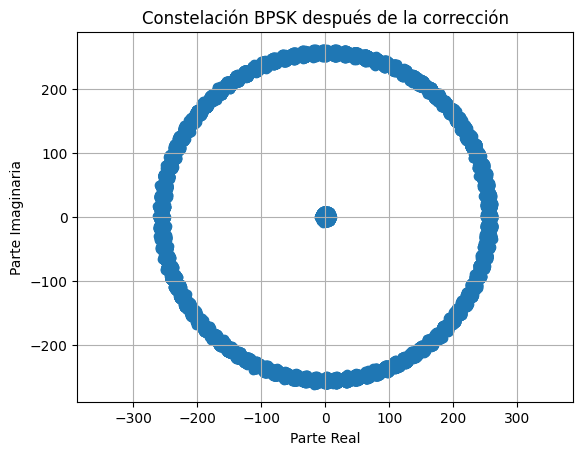

In [13]:
import matplotlib.pyplot as plt

plt.scatter(np.real(sampled_symbols), np.imag(sampled_symbols))
plt.title('Constelación BPSK después de la corrección')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()
